In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [2]:
movies = pd.read_csv("movies.csv")
movies = pd.concat([movies, movies['genres'].str.get_dummies(sep='|')], axis = 1)

ratings = pd.read_csv("ratings.csv")

remove_movie_ids = movies[movies['genres']=='(no genres listed)']['movieId']
ratings = ratings[~ratings['movieId'].isin(remove_movie_ids)]
movies = movies[~movies['movieId'].isin(remove_movie_ids)]

ratings = ratings[:100000].drop('timestamp', axis =1)

#ratings = ratings.sample(n = 10000)

ratings.describe()

,userId,movieId,rating
count,100000.000000,100000.000000,100000.000000
mean,387.823880,20762.808270,3.584945
std,220.759075,38049.017578,1.041426
min,1.000000,1.000000,0.500000
25%,187.000000,1089.000000,3.000000
50%,406.000000,2717.000000,4.000000
75%,572.000000,8368.000000,4.000000
max,757.000000,206272.000000,5.000000


In [63]:
user_ratings = ratings.pivot_table(index='userId', columns='movieId', values = 'rating', fill_value=0)
user_ratings[:2]

movieId,1,2,3,4,5,6,7,8,9,10,...,204542,204692,204698,204704,205054,205072,205106,205413,205557,206272
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,...,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0
2,3.5,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,...,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0


In [7]:
user_ratings = np.array(ratings.pivot_table(index='userId', columns='movieId', values = 'rating', fill_value=0))
user_ratings[:2]

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [3.5, 0. , 0. , ..., 0. , 0. , 0. ]])

In [4]:
user_ratings = csr_matrix(user_ratings)
user_ratings

<757x9737 sparse matrix of type '<class 'numpy.float64'>'
	with 100000 stored elements in Compressed Sparse Row format>

In [5]:
movies.movieId.count(), ratings.userId.nunique(), ratings.movieId.nunique()

(57361, 757, 9737)

Text(0.5, 1.0, 'Number of ratings per movie')

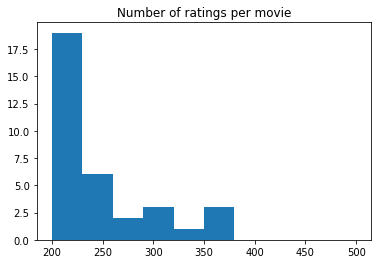

In [55]:
plt.hist(np.count_nonzero(user_ratings, axis = 0), range= [200,500])
plt.title("Number of ratings per movie")

Text(0.5, 1.0, 'Number of ratings per movie')

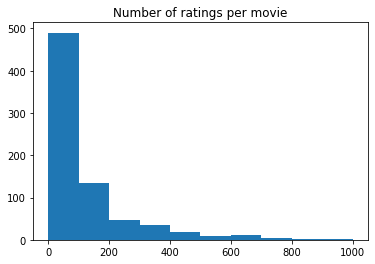

In [20]:
plt.hist(np.count_nonzero(user_ratings, axis = 1), range = [0, 1000])
plt.title("Number of ratings per user")

#### Exploratory Analysis

In [ ]:
movies[movies['movieId'].isin([np.where(np.count_nonzero(user_ratings, axis = 0) >= 200)][0][0] + 1)]

In [86]:
ratings.merge(movies, how = 'inner',left_on='movieId', right_on='movieId', )
ratings_movies[:2]

,userId,movieId,rating,title,genres,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


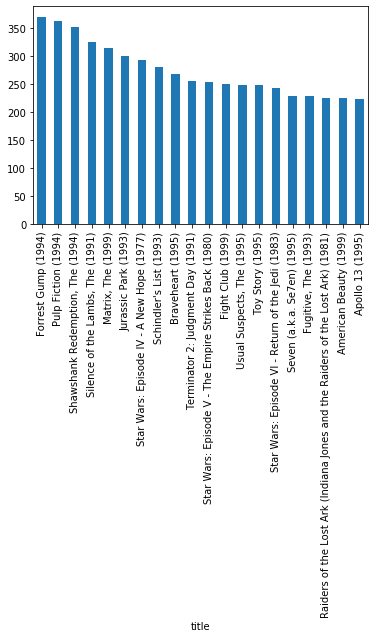

In [109]:
top_rated_5_movies = ratings_movies.groupby(by = 'title').count()['userId'].sort_values(ascending = False).nlargest(20)
top_rated_5_movies.plot.bar()

In [64]:
movies[movies['movieId'] == 1]

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
ratings[ratings['movieId'] == 32].shape

(216, 3)

In [11]:
X = ratings[ratings.userId == 1].drop(['userId','movieId','rating','title','timestamp','genres'], axis =1)
Y = ratings[ratings.userId == 1]['rating']
X.shape, Y.shape

((70, 20), (70,))

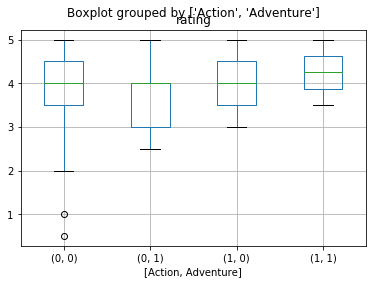

In [33]:
a= ratings[ratings['userId'] == 1]
a.boxplot(column = 'rating', by = ['Action','Adventure'])

In [12]:
reg = linear_model.LinearRegression().fit(X,Y)
reg.score(X,Y)

0.18709157038487212

In [27]:
reg.coef_

array([ 0.        ,  0.13769577,  0.1310475 ,  0.44606982, -0.23873975,
       -0.12934879,  0.22817104, -1.73878254, -0.0289584 , -0.13109029,
       -1.16134953, -0.20982414,  0.        , -0.60422685, -0.63928143,
        0.70860419, -0.21261693,  0.69439595,  0.20184132, -1.02786432])

In [18]:
m_pred = movies[movies['movieId']==1].drop(['title','genres','movieId'], axis = 1)
movies[movies['movieId'] ==1]

,movieId,title,genres,(no_genre),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
reg.predict(m_pred)

array([3.81672104])

<BarContainer object of 70 artists>

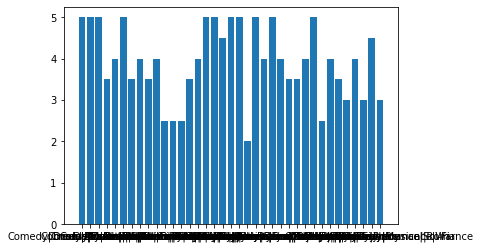

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(ratings[ratings['userId'] == 1]['genres'], ratings[ratings['userId'] == 1]['rating'])
# plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

In [24]:
ratings[(ratings['userId']==1) & (ratings['Adventure'] ==1)]

,userId,movieId,rating,timestamp,title,genres,(no_genre),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
10863,1,1250,4.0,1147868414,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
13946,1,2011,2.5,1147868079,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
15814,1,2012,2.5,1147868068,Back to the Future Part III (1990),Adventure|Comedy|Sci-Fi|Western,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
17731,1,2161,3.5,1147868609,"NeverEnding Story, The (1984)",Adventure|Children|Fantasy,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
18716,1,2632,5.0,1147878248,"Saragossa Manuscript, The (Rekopis znaleziony ...",Adventure|Drama|Mystery,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
28097,1,5952,4.0,1147868053,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
32227,1,6016,5.0,1147869090,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
33972,1,6377,4.0,1147868469,Finding Nemo (2003),Adventure|Animation|Children|Comedy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
36799,1,6539,3.5,1147868461,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
45946,1,8360,4.0,1147868682,Shrek 2 (2004),Adventure|Animation|Children|Comedy|Musical|Ro...,0,0,1,1,...,0,0,0,1,0,1,0,0,0,0


In [ ]:
movies_genre = movies[movies.columns.difference(['title','genres','(no genres listed)'])].set_index('movieId')[:15000]
movies_genre[:2]

In [ ]:
movies_1.shape

In [ ]:
cosine_sim = cosine_similarity(movies_1, movies_1)
cosine_similarities

In [ ]:
cosine_similarities.shape

In [ ]:
for idx, row in movies[:1000].iterrows():
   similar_indices = cosine_similarities[idx].argsort()[:-100:-1] 
   similar_items = [(cosine_similarities[idx][i], movies['movieId'][i]) for i in similar_indices] 
   results[row['movieId']] = similar_items[1:]

In [ ]:
results[1]

In [ ]:
movies[(movies['movieId'] == 673)]

In [ ]:
movies[(movies['movieId'] == 1)]

#### Collaborative based filtering

In [10]:
movies = pd.read_csv("movies.csv")
movies['genres'] = movies['genres'].str.replace('(no genres listed)','no_genre')

ratings = pd.read_csv("ratings.csv")
ratings = ratings[:100000].drop('timestamp', axis =1)
user_ratings = np.array(ratings.pivot_table(index='userId', columns='movieId', values = 'rating', fill_value=0))
user_ratings[:2]

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [3.5, 0. , 0. , ..., 0. , 0. , 0. ]])

In [12]:
ratings.shape

(100000, 3)

In [15]:
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]
print(str(n_users) + ' users')
print(str(n_items) + ' items')

757 users
9786 items


#### Train - Test Split

In [16]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [17]:
train, test = train_test_split(user_ratings)
train.shape, test.shape

((757, 9786), (757, 9786))

In [18]:
cos_sim = cosine_similarity(user_ratings, user_ratings)
cos_sim

array([[1.        , 0.04086293, 0.06130627, ..., 0.04551295, 0.12262044,
        0.03679557],
       [0.04086293, 1.        , 0.17900861, ..., 0.10063502, 0.29544433,
        0.13298351],
       [0.06130627, 0.17900861, 1.        , ..., 0.29562758, 0.36061809,
        0.11113104],
       ...,
       [0.04551295, 0.10063502, 0.29562758, ..., 1.        , 0.22072615,
        0.08615165],
       [0.12262044, 0.29544433, 0.36061809, ..., 0.22072615, 1.        ,
        0.27221364],
       [0.03679557, 0.13298351, 0.11113104, ..., 0.08615165, 0.27221364,
        1.        ]])

In [19]:
pear_sim = np.corrcoef(user_ratings)
pear_sim

array([[1.        , 0.03079982, 0.0419217 , ..., 0.03761295, 0.10870784,
        0.02113889],
       [0.03079982, 1.        , 0.15274956, ..., 0.08902474, 0.27768939,
        0.11093724],
       [0.0419217 , 0.15274956, 1.        , ..., 0.28065937, 0.32639582,
        0.06405958],
       ...,
       [0.03761295, 0.08902474, 0.28065937, ..., 1.        , 0.20572188,
        0.06801933],
       [0.10870784, 0.27768939, 0.32639582, ..., 0.20572188, 1.        ,
        0.2420602 ],
       [0.02113889, 0.11093724, 0.06405958, ..., 0.06801933, 0.2420602 ,
        1.        ]])

In [20]:
pear_sim_item = np.corrcoef(user_ratings.T)
pear_sim_item[:6,:6]

array([[1.        , 0.15836108, 0.19367021, 0.09791355, 0.15416541,
        0.12921531],
       [0.15836108, 1.        , 0.07729563, 0.06988842, 0.10292982,
        0.10905068],
       [0.19367021, 0.07729563, 1.        , 0.19407962, 0.36129567,
        0.19693618],
       [0.09791355, 0.06988842, 0.19407962, 1.        , 0.20664683,
        0.12064608],
       [0.15416541, 0.10292982, 0.36129567, 0.20664683, 1.        ,
        0.16497484],
       [0.12921531, 0.10905068, 0.19693618, 0.12064608, 0.16497484,
        1.        ]])

In [21]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

predict_fast_simple(user_ratings, pear_sim, kind='user')
predict_fast_simple(user_ratings, pear_sim_item, kind='item')


array([[ 0.01875327,  0.0189026 , -0.00441624, ...,  0.00532283,
         0.00532283,  0.00656005],
       [ 0.1765161 ,  0.12019583,  0.09570192, ...,  0.08959248,
         0.08959248,  0.02068097],
       [ 0.3938639 ,  0.30174065, -0.03898218, ...,  0.16670132,
         0.16670132,  0.58512633],
       ...,
       [ 0.06659539,  0.04696997, -0.03201391, ...,  0.02149137,
         0.02149137,  0.12603146],
       [ 0.31419612,  0.25172693,  0.12901581, ...,  0.13424279,
         0.13424279,  0.12341582],
       [ 0.27609467,  0.23447571,  0.26726035, ...,  0.14972277,
         0.14972277, -0.0272505 ]])

In [22]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[np.nonzero(actual)].flatten()
    actual = actual[np.nonzero(actual)].flatten()
    return mean_squared_error(pred, actual)

item_prediction = predict_fast_simple(user_ratings, pear_sim_item, kind='item')
user_prediction = predict_fast_simple(user_ratings, pear_sim, kind='user')

print('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 9.649841480135354
Item-based CF MSE: 13.701629165422089


In [24]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred


pred = predict_topk(train, pear_sim, kind='user', k=30)
print('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

pred = predict_topk(train, pear_sim_item, kind='item', k=30)
print('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))


/home/prajakta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/home/prajakta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Top-k User-based CF MSE: 8.557871044451836


/home/prajakta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/home/prajakta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Top-k Item-based CF MSE: 9.845788090996905


#### KNN

In [57]:
import surprise

from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV

  ##CrossValidation
from surprise.model_selection import cross_validate

from surprise import SVD
from surprise import NMF

reader = Reader(rating_scale=(0.5, 5)) #line_format by default order of the fields
data = Dataset.load_from_df(ratings[["userId","movieId","rating"]], reader=reader)

trainset = data.build_full_trainset()

testset = trainset.build_anti_testset()

In [59]:

def rmse_vs_factors(algorithm, data):
  """Returns: rmse_algorithm i.e. a list of mean RMSE of CV = 5 in cross_validate() for each  factor k in range(1, 101, 1)
  100 values 
  Arg:  i.) algorithm = Matrix factoization algorithm, e.g SVD/NMF/PMF, ii.)  data = surprise.dataset.DatasetAutoFolds
  """
  
  rmse_algorithm = []
  
  for k in range(1, 101, 1):
    algo = algorithm(n_factors = k)
    
    #["test_rmse"] is a numpy array with min accuracy value for each testset
    loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean() 
    rmse_algorithm.append(loss_fce)
  
  return rmse_algorithm

rmse_nmf = rmse_vs_factors(NMF, data)

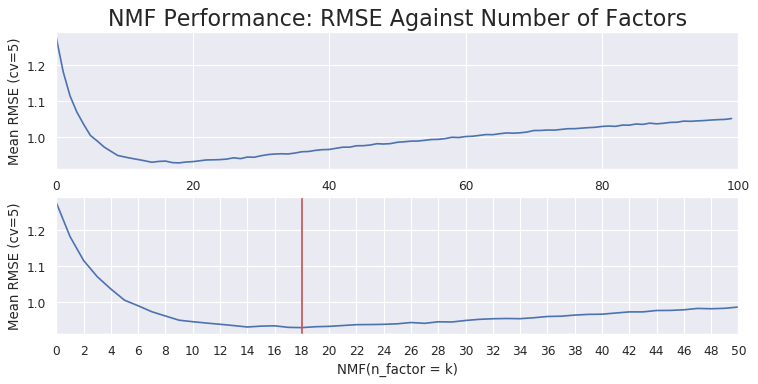

In [63]:
def plot_rmse(rmse, algorithm):
  """Returns: sub plots (2x1) of rmse against number of factors. 
     Vertical line in the second subplot identifies the arg for minimum RMSE
    
     Arg: i.) rmse = list of mean RMSE returned by rmse_vs_factors(), ii.) algorithm = STRING! of algo 
  """
  
  plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

  plt.subplot(2,1,1)
  plt.plot(rmse)
  plt.xlim(0,100)
  plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
  plt.ylabel("Mean RMSE (cv=5)")

  plt.subplot(2,1,2)
  plt.plot(rmse)
  plt.xlim(0,50)
  plt.xticks(np.arange(0, 52, step=2))

  plt.xlabel("{0}(n_factor = k)".format(algorithm))
  plt.ylabel("Mean RMSE (cv=5)")
  plt.axvline(np.argmin(rmse), color = "r")

plot_rmse(rmse_nmf,"NMF")

In [80]:
np.where(np.count_nonzero(train, axis = 0) == 0)[0][0]

213

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([1500., 1575., 1650., 1725., 1800., 1875., 1950., 2025., 2100.,
        2175., 2250., 2325., 2400., 2475., 2550., 2625., 2700., 2775.,
        2850., 2925., 3000.]),
 <a list of 20 Patch objects>)

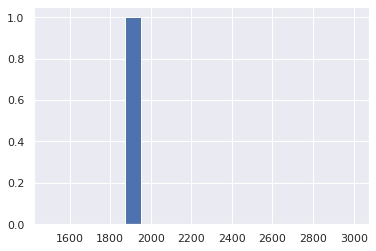

In [99]:
plt.hist(np.count_nonzero(train, axis = 1), bins = 20, range= [1500, 3000])

(array([ 139., 3849., 1267.,  697.,  497.,  366.,  317.,  230.,  184.,
         152.,  155.,  123.,  104.,  100.,  102.,   88.,   65.,   62.,
          65.,  106.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <a list of 20 Patch objects>)

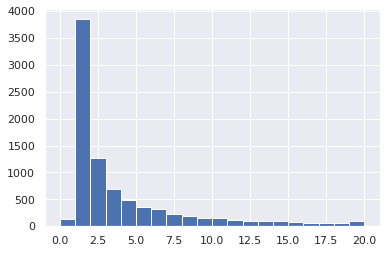

In [95]:
plt.hist(np.count_nonzero(train, axis = 0), bins = 20, range= [0,20])